In [2]:
%matplotlib widget
# Add the directory containing the package to sys.path
import sys, os
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Outils/swd")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
    
from swd import spherical_processing as sp
from swd import geotools as geo
from swd import plots as splots
import swd as swd
import importlib

importlib.reload(swd.plots)
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt

import warnings
#from utils_DirViolins import *
warnings.filterwarnings("ignore")
from tqdm import tqdm
np.set_printoptions(precision=2, suppress=True)
# Enable LaTeX rendering
plt.rc('text', usetex=True)
# Improve resolution
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

In [3]:
#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
NbMems = 256
NbViolTot = 6
NbViol = 6
OSH = 7
Dyn = 36

NbSH = (OSH+1)**2
NumViolon = np.load('./../results/NumViolon.npz')['NumViolon']
XYZViolins = np.load('./../results/XYZViolinsAligned.npy')

NbMics = 256
NbSrcs = XYZViolins.shape[0] - NbMics

XYZHammerImpact = XYZViolins[NbSrcs-1]
XYZ = XYZViolins-XYZHammerImpact
XYZs = XYZ[:NbSrcs-1]
XYZm = XYZ[NbSrcs:]
XYZHammerImpact = XYZ[NbSrcs-1]

In [4]:
# Violin positioning
# Define rotation functions locally to avoid dependency issues
def x_rotate_coordinates(coords, a):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a), np.cos(a)]
    ])
    return np.dot(R_x, coords)

def y_rotate_coordinates(coords, a):
    R_y = np.array([
        [np.cos(a), 0, np.sin(a)],
        [0, 1, 0],
        [-np.sin(a), 0, np.cos(a)]
    ])
    return np.dot(R_y, coords)

def z_rotate_coordinates(coords, a):
    R_z = np.array([
        [np.cos(a), -np.sin(a), 0],
        [np.sin(a), np.cos(a), 0],
        [0, 0, 1]
    ])
    return np.dot(R_z, coords)

import trimesh
#Dimensions hors tout du violon Stradivarius Willemotte 1732, d'apres les mesures de Sacconi:
Wv = 206.5e-3  # Convert mm to meters
Lv = 485.7e-3
Hv = 94.7e-3

mesh = trimesh.load('../src/Meshes/violin.ply')  # Can also load .obj or .mtl files
# Extract vertices and faces
vertices = mesh.vertices
vertices -= vertices.mean(axis=0)
rx = 90 * pi/180 
ry = 0 * pi/180 
rz = -90 * pi/180
vertices = x_rotate_coordinates(vertices.T,    rx).T
vertices = y_rotate_coordinates(vertices.T,    ry).T
vertices = z_rotate_coordinates(vertices.T,    rz).T

Dims0 = vertices.max(axis=0) - vertices.min(axis=0)
DimsV = np.array([Hv, Wv, Lv])

Scale = DimsV / Dims0
vertices *= Scale
SommetChevalet = vertices[np.abs(vertices[:,0]).argmax()]
vertices -= SommetChevalet
faces = mesh.faces

In [5]:
Pm = np.load('./../results/ViolinsFRFsAndRIs.npz')['Hhm']
frq = np.load('./../results/ViolinsFRFsAndRIs.npz')['frq']

NbTh = 52   #Nombre de theta                                    
NbPh = 52   #Nombre de phi
frqMax = 12500
CyclicScale = 'icefire' #edge, icefire, phase, hsv
RealScale = 'seismic'
Magnitudescale = 'inferno'

## Process the Spherical Harmonics Spectra for one Violin

In [6]:
Rm = np.linalg.norm(XYZm,axis=1)
Rmin = np.min(Rm)

In [58]:

Band = (frq>0) & (frq<frqMax)
f = frq[Band]
Nbf = len(f)
kvect= 2*pi*f.T/C
Nang = 100
NbTh, NbPh = 2*Nang+2, 2*Nang+2
angles_look, weights = swd.geotools.create_equal_angle_grid(Nang)

In [59]:
XYZm1 = XYZm
O_SH_vect = sp.compute_N_SH_vect(f,N_SH_max = OSH,rmin = Rmin)
Ho2f = sp.compute_SphericalWavesbasis_origin_to_field(XYZm1, kvect, OSH, SH_center = np.array([0,0,0], dtype = float))
NbDirs = angles_look.shape[0]

Cmn1 = np.zeros((NbSH, Nbf), dtype = np.complex128)    
Diag1 = np.zeros((NbDirs, Nbf), dtype = np.complex128)
NumV = 0
P  = Pm[NumV,Band,:].T
Cmn1 = sp.compute_SHcoefs(P,Ho2f,O_SH_vect, lambda_reg=1e-4)
Diag1 = sp.compute_Dinf_from_SH_coefs_at_origin(Cmn1, angles_look, kvect)

In [60]:
rx = 0 * pi/180 
ry = 0 * pi/180 
rz = 45 * pi/180
XYZm2 = x_rotate_coordinates(XYZm.T,    rx).T
XYZm2 = y_rotate_coordinates(XYZm2.T,    ry).T
XYZm2 = z_rotate_coordinates(XYZm2.T,    rz).T

Ho2f = sp.compute_SphericalWavesbasis_origin_to_field(XYZm2, kvect, OSH, SH_center = np.array([0,0,0], dtype = float))
NbDirs = angles_look.shape[0]

Cmn2 = np.zeros((NbSH, Nbf), dtype = np.complex128)    
Diag2 = np.zeros((NbDirs, Nbf), dtype = np.complex128)
NumV = 0
P  = Pm[NumV,Band,:].T
Cmn2 = sp.compute_SHcoefs(P,Ho2f,O_SH_vect, lambda_reg=1e-4)
Diag2 = sp.compute_Dinf_from_SH_coefs_at_origin(Cmn2, angles_look, kvect)

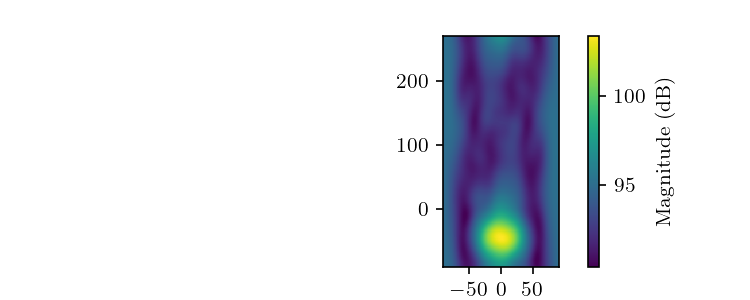

In [61]:
XS12 = Cmn1 * np.conj(Cmn2)
XC12 = sp.compute_Dinf_from_SH_coefs_at_origin(XS12, angles_look, kvect).reshape(NbPh, NbTh, Nbf)
WBXC12 = np.sum(np.abs(XC12)**2, axis=2)
plt.figure(figsize=(5, 2))
plt.imshow(np.abs(10*np.log10(WBXC12)), aspect='equal', origin='lower', interpolation = 'None',extent=[-90, 90, -90, 270])
plt.colorbar(label='Magnitude (dB)')


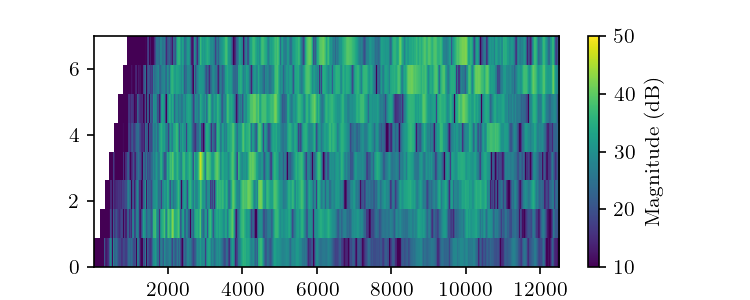

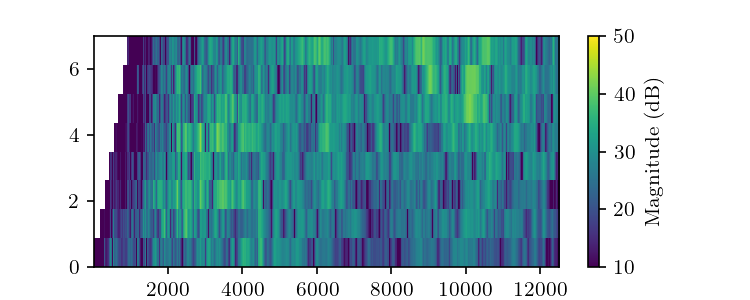

In [24]:
OSHSpec1 = []
OSHSpec2 = []
no = 0
for o in range(OSH+1):
    sho = np.arange(2*o+1) + no
    no = sho[-1]+1
    OSHSpec1.append(np.abs(np.sum(Cmn1[sho,:], axis = 0))**2)
    OSHSpec2.append(np.abs(np.sum(Cmn2[sho,:], axis = 0))**2)
OSHSpec1 = np.array(OSHSpec1)
OSHSpec2 = np.array(OSHSpec2)
plt.figure(figsize=(5, 2))
plt.imshow(10*np.log10(OSHSpec1), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, OSH], interpolation = 'None', vmin = 10, vmax = 50)
plt.colorbar(label='Magnitude (dB)')
plt.figure(figsize=(5, 2))
plt.imshow(10*np.log10(OSHSpec2), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, OSH], interpolation = 'None', vmin = 10, vmax = 50)
plt.colorbar(label='Magnitude (dB)')

